In [199]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from halp.undirected_hypergraph import UndirectedHypergraph
from halp.utilities import undirected_graph_transformations, undirected_matrices
import scipy

## Investigating Random Walks on $(d,k)$-regular hypergraphs

$(d,k)$-regular is a hypergraph that is both d-regular and k-uniform.
- $d$-regular: hypergraph with all of its vertices having degree $d$
- $k$-uniform: every hyperedge of a hypergraph contains exactly $k$ node

In [200]:
# generating a (d,k)-regular hypergraph

H = UndirectedHypergraph()
H.add_nodes(list(range(9)))

# (2,3) graph
H.add_hyperedge([0,1,2])
H.add_hyperedge([3,4,5])
H.add_hyperedge([6,7,8])
H.add_hyperedge([0,3,6])
H.add_hyperedge([1,5,8])
H.add_hyperedge([2,4,7])

node_map = undirected_matrices.get_node_mapping(H)[1]
edge_map = undirected_matrices.get_hyperedge_id_mapping(H)[1]

I = undirected_matrices.get_incidence_matrix(H, node_map, edge_map).toarray()
np.shape(I)

(9, 6)

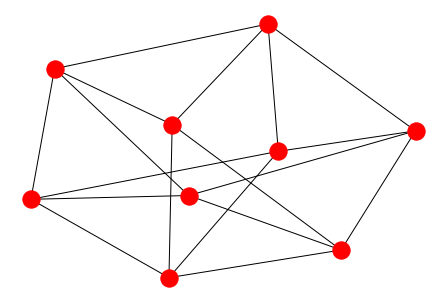

In [201]:
A = I.dot(I.T)
A = A -np.diag(np.diag(A))

nx_graph = nx.from_numpy_matrix(A)
nx.draw(nx_graph)

In [202]:
# simple common random walk

def walker_1(H, start_node, num_steps):
    node = start_node
    hist = []

    for i in range(num_steps):
        hist.append(node)
        edges = list(H.get_star(node))
        # randomly select next hyperedge
        e = np.random.choice(edges)
        # select next node (not the current node)
        nodes = [node_iter for node_iter in H.get_hyperedge_nodes(e) if node_iter != node]
        node = np.random.choice(nodes)
        
    return hist

In [203]:
D_v = 2*np.identity(9)
D_e = 3*np.identity(6)

In [204]:
A = I @ np.linalg.inv(D_e - np.identity(6)) @ I.T
A = A - np.diag(np.diag(A))
T = np.linalg.inv(D_v) @ A

In [205]:
T

array([[0.  , 0.25, 0.25, 0.25, 0.  , 0.  , 0.25, 0.  , 0.  ],
       [0.25, 0.  , 0.25, 0.  , 0.  , 0.25, 0.  , 0.  , 0.25],
       [0.25, 0.25, 0.  , 0.  , 0.25, 0.  , 0.  , 0.25, 0.  ],
       [0.25, 0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.25, 0.  , 0.25, 0.  , 0.25, 0.  ],
       [0.  , 0.25, 0.  , 0.25, 0.25, 0.  , 0.  , 0.  , 0.25],
       [0.25, 0.  , 0.  , 0.25, 0.  , 0.  , 0.  , 0.25, 0.25],
       [0.  , 0.  , 0.25, 0.  , 0.25, 0.  , 0.25, 0.  , 0.25],
       [0.  , 0.25, 0.  , 0.  , 0.  , 0.25, 0.25, 0.25, 0.  ]])

In [206]:
hist = walker_1(H, 0, 5000)

In [207]:
hist_res = []

for node in list(H.get_node_set()):
    hist_res.append(len([item for item in hist if item == node]))

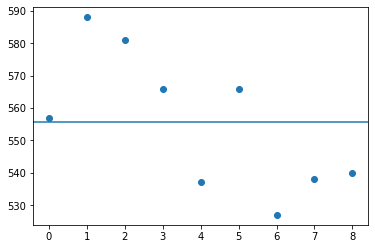

In [208]:
plt.scatter(list(H.get_node_set()), hist_res)
plt.axhline(5000/9)

### Finding the mixing time of the random walk

According to (XXX), the mixing rate of a random walk on a $(d,k)$ graph is given by 
$$
\frac{\lambda}{(k-1)d}
$$
where $\lambda$ is the second largest abs. value eigenvalue of the adjacency matrix $A$.

In [209]:
#We have to transpose so that Markov transitions correspond to right multiplying by a column vector.  np.linalg.eig finds right eigenvectors.
evals, evecs = np.linalg.eig(T.T)
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real

In [210]:
stationary

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

In [211]:
evals

array([-0.5 ,  0.25,  1.  ,  0.25, -0.5 ,  0.25, -0.5 ,  0.25, -0.5 ])

In [212]:
evec2 = evecs[:,np.isclose(evals, -0.5)]
evec2

array([[ 0.66666667, -0.01774398,  0.03804704, -0.01605836],
       [-0.33333333,  0.1913815 , -0.58959399,  0.31469363],
       [-0.33333333, -0.17363752,  0.55154696, -0.29863527],
       [-0.33333333,  0.55640051, -0.01091116, -0.12013701],
       [ 0.16666667, -0.1869455 , -0.20930745,  0.62206037],
       [ 0.16666667, -0.36945501,  0.22021861, -0.50192337],
       [-0.33333333, -0.53865653, -0.02713587,  0.13619536],
       [ 0.16666667,  0.36058302, -0.3422395 , -0.3234251 ],
       [ 0.16666667,  0.17807351,  0.36937538,  0.18722974]])

In [213]:
evec2 = evec2[:,0]

In [214]:
evec2

array([ 0.66666667, -0.33333333, -0.33333333, -0.33333333,  0.16666667,
        0.16666667, -0.33333333,  0.16666667,  0.16666667])

In [215]:
mix_time = np.abs(-0.5)

In [216]:
def walker_1(graph, start_node, num_steps, stat_dist_dict):
    node = start_node
    hist = []
    hist_dict = {}
    for node in graph.get_node_set():
        hist_dict[node] = 0
    norm_hist = []

    for i in range(1, num_steps):
        
        hist_dict[node] += 1
        hist.append(node)
        edges = list(graph.get_star(node))
        # randomly select next hyperedge
        e = np.random.choice(edges)
        # select next node (not the current node)
        nodes = [node_iter for node_iter in graph.get_hyperedge_nodes(e) if node_iter != node]
        node = np.random.choice(nodes)
        
        if i % 1 == 0:
            norm = 0
            # evaluate norm difference between current walk and the stationary distribution
            for nodes in graph.get_node_set():
                norm += ((hist_dict[nodes] / i) - stat_dist_dict[nodes])**2
            norm = norm**0.5
            norm_hist.append(norm)
    return hist, norm_hist, hist_dict

In [217]:
stat_dict = {}
for node in H.get_node_set():
    stat_dict[node] = stationary[0]

In [218]:
hist, norm_hist, hist_dict = walker_1(H, 0, 10000, stat_dict)

In [219]:
hist_dict

{0: 1183,
 1: 1064,
 2: 1109,
 3: 1137,
 4: 1105,
 5: 1092,
 6: 1129,
 7: 1099,
 8: 1081}

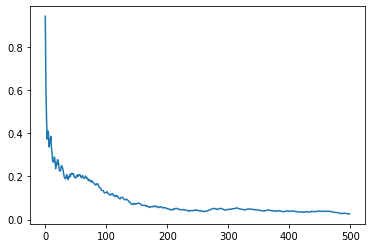

In [220]:
plt.plot(norm_hist[:500])


## Different $(d,k)$-regular hypergraph (Fano Plane)

In [221]:
G = UndirectedHypergraph()
G.add_nodes(list(range(1,8)))
G.add_hyperedge([1,2,3])
G.add_hyperedge([1,4,5])
G.add_hyperedge([3,6,5])
G.add_hyperedge([2,4,6])
G.add_hyperedge([2,4,6])
G.add_hyperedge([1,7,6])
G.add_hyperedge([3,7,4])
G.add_hyperedge([2,7,5])

'e7'

In [222]:
node_map = undirected_matrices.get_node_mapping(G)[1]
edge_map = undirected_matrices.get_hyperedge_id_mapping(G)[1]

I = undirected_matrices.get_incidence_matrix(G, node_map, edge_map).toarray()
np.shape(I)

(7, 7)

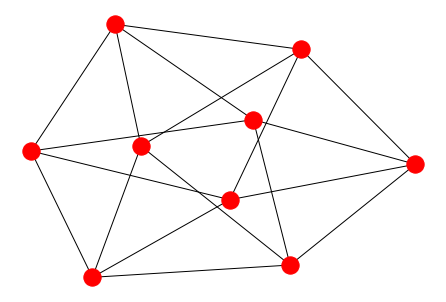

In [223]:
nx_graph = nx.from_numpy_matrix(A)
nx.draw(nx_graph)

D_v = 3*np.identity(7)
D_e = 3*np.identity(7)

A = I @ np.linalg.inv(D_e - np.identity(7)) @ I.T
A = A - np.diag(np.diag(A))
T = np.linalg.inv(D_v) @ A

In [224]:
#We have to transpose so that Markov transitions correspond to right multiplying by a column vector.  np.linalg.eig finds right eigenvectors.
evals, evecs = np.linalg.eig(T.T)
evec1 = evecs[:,np.isclose(evals, 1)]

#Since np.isclose will return an array, we've indexed with an array
#so we still have our 2nd axis.  Get rid of it, since it's only size 1.
evec1 = evec1[:,0]

stationary = evec1 / evec1.sum()

#eigs finds complex eigenvalues and eigenvectors, so you'll want the real part.
stationary = stationary.real

In [225]:
stationary

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

In [226]:
evals

array([-0.16666667,  1.        , -0.16666667, -0.16666667, -0.16666667,
       -0.16666667, -0.16666667])

In [227]:
evec2 = evecs[:,np.isclose(evals, -0.16666667)]

In [228]:
evalue = np.abs(-0.16666667)

In [229]:
rate = evalue / (3*2)

In [230]:
stat_dict = {}
for node in G.get_node_set():
    stat_dict[node] = stationary[0]

In [237]:
hist, norm_hist2, hist_dict = walker_1(G, 1, 10000, stat_dict)

In [238]:
hist_dict

{1: 1412, 2: 1437, 3: 1418, 4: 1476, 5: 1446, 6: 1451, 7: 1359}

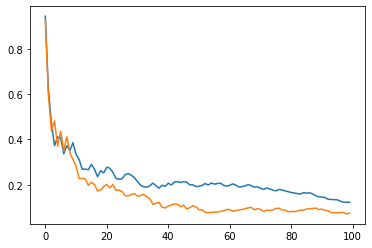

In [239]:
plt.plot(norm_hist[:100])
plt.plot(norm_hist2[:100])

In [234]:
0.5 / (2*2)

0.125

In [235]:
0.16667 / (2*3)

0.027778333333333335